In [ ]:
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt

In [ ]:
k = 5  # W m-1 K-1
h = 200  # W m-2 K-1
r = 1e-2  # m
L = 0.1  # m
T_b = 398  # K
T_inf = 298  # K

The general fin equation is given by

$$
\frac{d^2 \theta}{dx^2}
+ \left( \frac{1}{A_c} \frac{d A_c}{dx} \right) \frac{d \theta}{dx}
- \frac{h P}{k A_c} \theta
= 0
$$
where $\theta{(x)} \equiv T{(x)} - T_{\infty}$.

In state-space form,
\begin{gathered}
    \begin{align*}
        y_0 &= \theta{(x)} & y_1 &= \theta'{(x)} = \frac{d \theta}{dx}
    \end{align*}\\
    \begin{equation*}
        \frac{d \textbf{y}}{dx}
        = \begin{bmatrix} y'_0 \\ y'_1 \end{bmatrix}
        = \begin{bmatrix} \theta' \\ \theta'' \end{bmatrix}
        = \begin{bmatrix} y_1 \\ - \left( \frac{1}{A_c} \frac{d A_c}{dx} \right) y_1 + \frac{h P}{k A_c} y_0 \end{bmatrix}
    \end{equation*}
\end{gathered}

In [ ]:
def deriv(x, y):
    y0, y1 = y
    return np.vstack(
        [
            y1,
            # circular pin fin
            (2 * h) / (k * r) * y0,  # dAc/dx = 0
        ]
    )

In [ ]:
def bc(ya, yb):
    return np.array(
        [
            ya[0] - (T_b - T_inf),  # y0(x=a) = T_b - T_inf
            yb[0],  # y0(x=b) = 0; "infinite" fin
        ]
    )

In [ ]:
x = np.linspace(0, L, 5)
y = np.zeros((2, x.size))

In [ ]:
result = scipy.integrate.solve_bvp(fun=deriv, bc=bc, x=x, y=y)

x_plot = np.linspace(0, L, 1001)
T_plot, dT_plot = result.sol(x_plot)

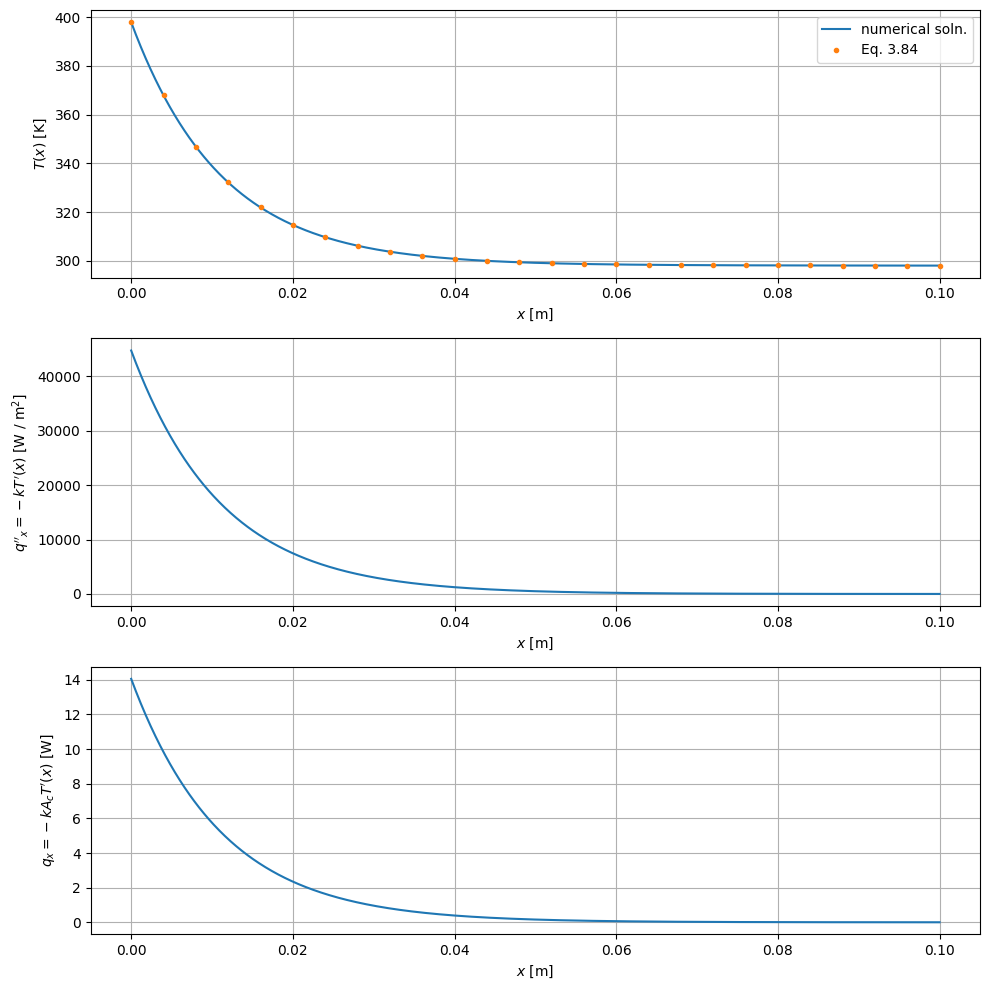

In [ ]:
fig = plt.figure(1, figsize=(10, 10))
gc = fig.add_gridspec(3, 1)

ax = fig.add_subplot(gc[0, 0])
ax.plot(x_plot, T_inf + T_plot, label="numerical soln.")
m = np.sqrt((2 * h) / (k * r))
ax.plot(
    x_plot,
    T_inf + np.exp(-m * x_plot) * (T_b - T_inf),
    ".",
    markevery=40,
    label="Eq. 3.84",
)
ax.legend()
ax.set_ylabel(r"$T{(x)}$ [K]")

ax = fig.add_subplot(gc[1, 0])
ax.plot(x_plot, -k * dT_plot)
ax.set_ylabel(r"$q''_x = -k T'{(x)}$ [W / m$^2$]")

ax = fig.add_subplot(gc[2, 0])
A_c = np.pi * r**2
ax.plot(x_plot, -k * A_c * dT_plot)
ax.set_ylabel(r"$q_x = -k A_c T'{(x)}$ [W]")

for ax in fig.axes:
    ax.grid(True)
    ax.set_xlabel(r"$x$ [m]")
plt.tight_layout()